# Modeling resting-state MEG data

In this example, we will simlate resting state functional connectivity of MEG recordings.

In [5]:
import brainstate
import braintools
import brainmass
import xarray as xr
from scipy.signal import resample, butter, filtfilt, hilbert
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets

## Perform simulations to generate synthetic data

<h1 style="font-size:1em;">Load MEG data and use wilson-wowan model to build the brain network.</h1>

In [6]:
from datasets import Dataset
brainstate.environ.set(dt=0.1)

plt.rcParams['image.cmap'] = 'plasma'
hcp = Dataset('hcp')
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1.):
        super().__init__()

        conn_weight = hcp.Cmat
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp.Dmat / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.tile(np.arange(conn_weight.shape[1]), conn_weight.shape[0])

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=0.01),
            noise_I=brainmass.OUProcess(80, sigma=0.01),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time.flatten(), indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

Loading dataset hcp from /home/ubuntu/fyx/brainmass/examples/datasets/hcp.
Dataset hcp loaded.


In [7]:
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // brainstate.environ.get_dt())
exes = brainstate.transform.for_loop(net.step_run, indices)

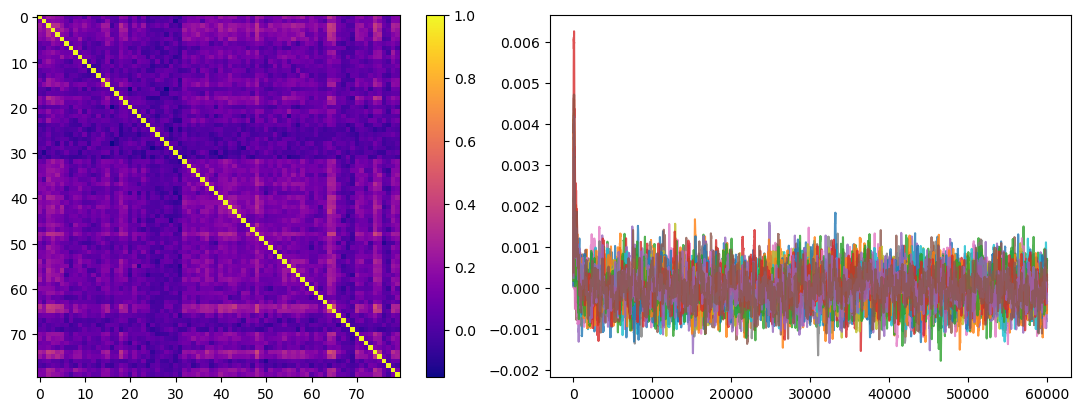

In [9]:
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes[:, ::5], alpha=0.8)
plt.show()

Next, we perform a series of neural-dynamics processing steps on the raw simulated activity—resampling, band-pass filtering, amplitude-envelope extraction, and low-pass filtering—to bring the synthetic signal into closer agreement with real MEG data.


In [11]:
dt_ms = brainstate.environ.get_dt()
original_fs = 1000. / dt_ms 
num_regions = exes.shape[1]
time_points_orig = indices * dt_ms / 1000. 

region_labels = [f'Region_{i}' for i in range(num_regions)]
sim_signal_raw = xr.DataArray(
    exes, 
    dims=("time", "regions"), 
    coords={"time": time_points_orig, "regions": region_labels}
)

Down-sampling the ultra-high 10 kHz simulated signal to 100 Hz so that subsequent analyses can be carried out within the 0–50 Hz range, just as with real MEG data.

In [12]:
# resample
target_fs = 100.0 
num_samples_new = int(len(time_points_orig) * target_fs / original_fs)
resampled_data, resampled_time = resample(sim_signal_raw, num_samples_new, t=time_points_orig)

sim_signal = xr.DataArray(
    resampled_data,
    dims=("time", "regions"),
    coords={"time": resampled_time, "regions": region_labels}
)
print(f"Original sampling rate: {original_fs} Hz. Resampled to: {target_fs} Hz.")

Original sampling rate: 10000.0 Hz. Resampled to: 100.0 Hz.


Define a band-pass and a low-pass Butterworth filter to prepare for subsequent frequency-specific analyses.

In [13]:
#  bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# low-pass filter
def butter_lowpass_filter(data, highcut, fs, order=3):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, [high], btype='low')
    y = filtfilt(b, a, data)
    return y

Filter the signal to the 8–12 Hz α-band, apply the Hilbert transform to obtain the analytic signal and extract the instantaneous amplitude envelope, and finally low-pass filter it to reveal the slow dynamics.

In [14]:
target_region = 'Region_0' # 选择第一个脑区进行分析
signal_to_process = sim_signal.sel(regions=target_region).values

# bandpass filter
freq_band = [8.0, 12.0]    # α
filtered_signal = butter_bandpass_filter(signal_to_process, freq_band[0], freq_band[1], fs=target_fs)

# hilbert
analytic_signal = hilbert(filtered_signal)
signal_envelope = np.abs(analytic_signal)

# low-pass
low_pass_cutoff = 4.0
smoothed_envelope = butter_lowpass_filter(signal_envelope, low_pass_cutoff, fs=target_fs)

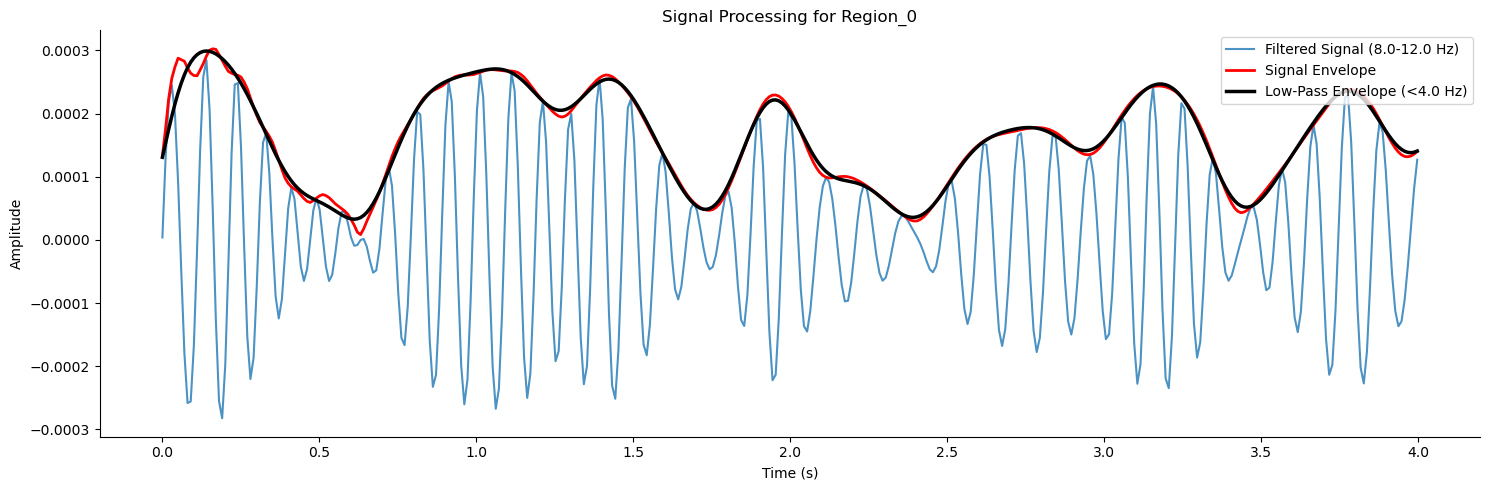

In [15]:
fig_signal, ax_signal = plt.subplots(figsize=(15, 5))
plot_duration_s = 4 # 画4秒
plot_timepoints = int(plot_duration_s * target_fs)
time_axis = sim_signal.time.values[:plot_timepoints]
ax_signal.plot(time_axis, filtered_signal[:plot_timepoints], label=f'Filtered Signal ({freq_band[0]}-{freq_band[1]} Hz)', alpha=0.8)
ax_signal.plot(time_axis, signal_envelope[:plot_timepoints], label='Signal Envelope', linewidth=2, color='red')
ax_signal.plot(time_axis, smoothed_envelope[:plot_timepoints], label=f'Low-Pass Envelope (<{low_pass_cutoff} Hz)', linewidth=2.5, color='black')
ax_signal.set_title(f'Signal Processing for {target_region}')
ax_signal.set_xlabel('Time (s)')
ax_signal.set_ylabel('Amplitude')
ax_signal.legend(loc='upper right')
ax_signal.spines['top'].set_visible(False)
ax_signal.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Process real MEG data

load MEG data

In [16]:
meg_data = xr.open_dataset('datasets/rs-meg.nc')
region_labels = meg_data.regions.values
sampling_rate = 1 / (meg_data.time[1] - meg_data.time[0]).item() # Calculate sampling rate from time coordinates
print(f"Data loaded with {len(region_labels)} regions. Sampling rate: {sampling_rate:.2f} Hz")

Data loaded with 94 regions. Sampling rate: 100.00 Hz


In [17]:
print('Select a region from the AAL2 atlas and a frequency range')
# Select a Region 
target = widgets.Select(options=region_labels, value='PreCG.L', description='Regions', 
                        tooltips=['Description of slow', 'Description of regular', 'Description of fast'], 
                        layout=widgets.Layout(width='50%', height='150px'))
display(target)

# Select Frequency Range
freq = widgets.IntRangeSlider(min=1, max=46, description='Frequency (Hz)', value=[8, 12], layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
display(freq)

plot_timepoints = 1000

meg_array = meg_data['__xarray_dataarray_variable__']
if meg_array.dims[0] != 'time':
    meg_array = meg_array.transpose('time', 'regions')    
fs = sampling_rate                                   
low, high = freq.value                              
plot_len = int(plot_timepoints)                     
time_vals = meg_array.time[:plot_len].values 

Select a region from the AAL2 atlas and a frequency range


Select(description='Regions', layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.R', 'SFG.…

IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=46, min=1, style=S…

Filter the time series of the selected brain region and plot both the original and filtered signals.

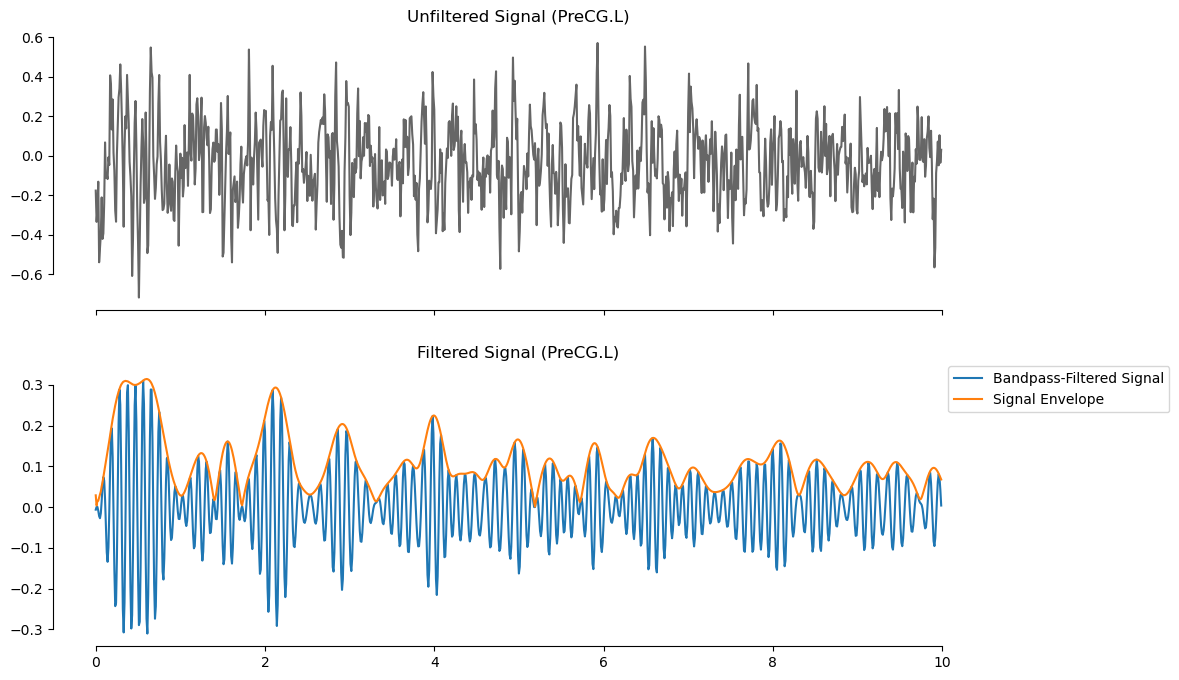

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
y_raw_target = meg_array.sel(regions=target.value).values 
sns.lineplot(x=time_vals, y=y_raw_target[:plot_len], ax=ax[0], color='k', alpha=0.6)
ax[0].set_title(f'Unfiltered Signal ({target.value})')

# Band Pass Filter the Signal
y_filt_target = butter_bandpass_filter(y_raw_target, low, high, fs)
y_env_target  = np.abs(hilbert(y_filt_target))  

sns.lineplot(x=time_vals, y=y_filt_target[:plot_len], ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=time_vals, y=y_env_target[:plot_len], ax=ax[1], label='Signal Envelope')
ax[1].set_title(f'Filtered Signal ({target.value})');
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
sns.despine(trim=True)
plt.show()

Next, we orthogonalize the signals. MEG recordings are mixtures of multiple neural sources, and electric-field spread creates spurious functional connections—two sensors may pick up the same underlying source. To counter this, we remove the component of each target signal that shares phase with a reference region, preserving only the neural activity that is independent of that reference. This orthogonalization improves the spatial specificity and reliability of MEG connectivity estimates.

$$
Y_{ix}(t, f) = \text{imag}\left(\frac{Y(t, f)}{X(t, f)^*}\right)
$$

 Y represents the analytic signal from our target regions that is being orthogonalized with respect to the signal from region X.

In [19]:
# Orthogonalized signal envelope
print('Select a reference region for the orthogonalization')
# Select a Region 
referenz = widgets.Select(options=region_labels, value='PreCG.R', description='Regions',
                          tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
                          layout=widgets.Layout(width='50%', height='150px'))
display(referenz)

y_raw_reference = meg_array.sel(regions=referenz.value).values
y_filt_reference = butter_bandpass_filter(y_raw_reference, low, high, fs)

complex_target = hilbert(y_filt_target)
complex_reference = hilbert(y_filt_reference)
env_reference = np.abs(complex_reference)
env_target = np.abs(complex_target)

signal_conj_div_env = complex_reference.conj() / env_reference
orth_signal_imag = (complex_target * signal_conj_div_env).imag
orth_env = np.abs(orth_signal_imag)

Select a reference region for the orthogonalization


Select(description='Regions', index=1, layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.…

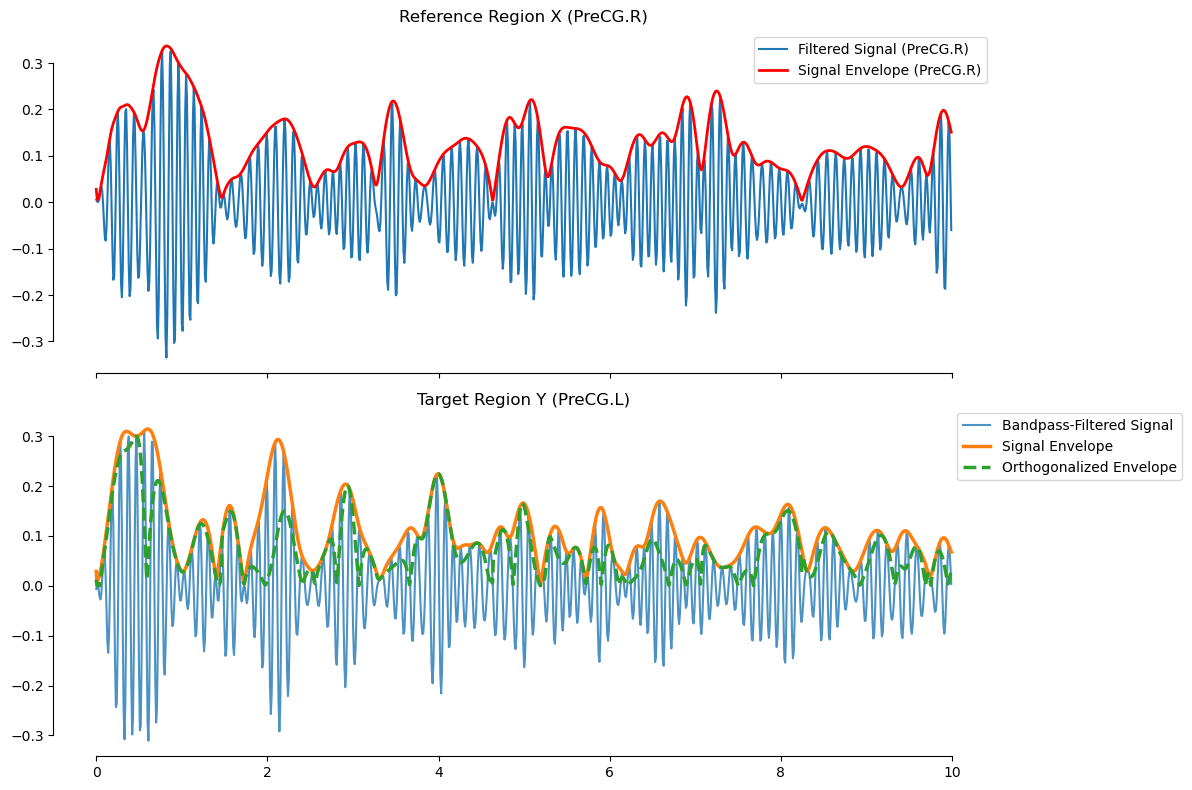

In [20]:
fig_final, ax_final = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax_final[0].plot(time_vals, y_filt_reference[:plot_len], label=f'Filtered Signal ({referenz.value})')
ax_final[0].plot(time_vals, env_reference[:plot_len], label=f'Signal Envelope ({referenz.value})', color='red', linewidth=2)
ax_final[0].set_title(f'Reference Region X ({referenz.value})')
ax_final[0].legend()

ax_final[1].plot(time_vals, y_filt_target[:plot_len], label='Bandpass-Filtered Signal', alpha=0.8)
ax_final[1].plot(time_vals, env_target[:plot_len], label='Signal Envelope', linewidth=2.5)
ax_final[1].plot(time_vals, orth_env[:plot_len], label='Orthogonalized Envelope', linewidth=2.5, linestyle='--')
ax_final[1].set_title(f'Target Region Y ({target.value})')
ax_final[1].legend(bbox_to_anchor=(1.2, 1), borderaxespad=0)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

Apply an identical low-pass filter to both the reference envelope and the orthogonalized envelope to isolate their slow-frequency components.

FloatSlider(value=1.0, description='Low-Pass Frequency (Hz)', layout=Layout(width='80%'), max=2.0, readout_for…

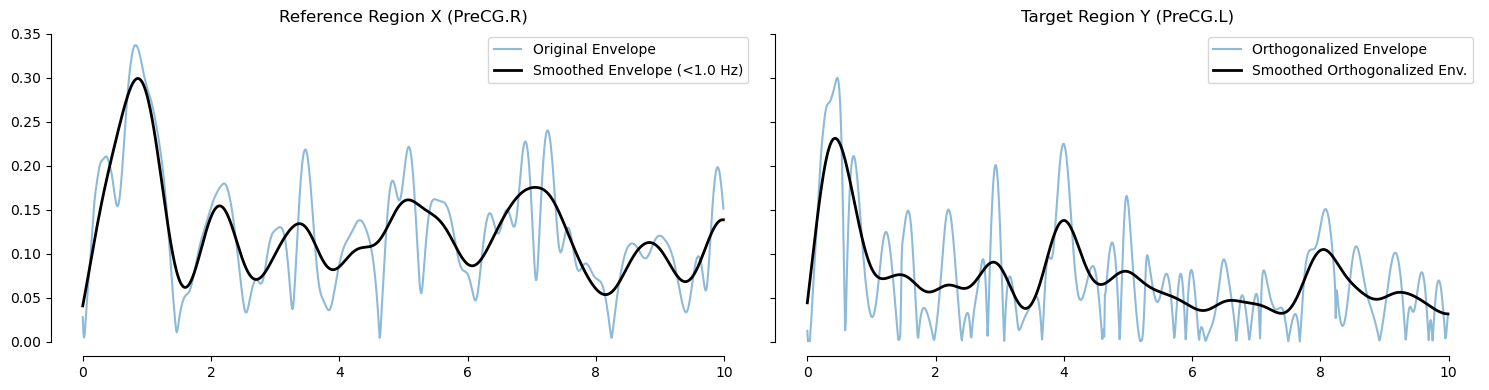


Orthogonalized envelope correlation between PreCG.R and PreCG.L: 0.20


In [21]:
low_pass = widgets.FloatSlider(value=1.0, min=0, max=2.0, step=0.1, description='Low-Pass Frequency (Hz)', 
                               disabled=False, readout=True, readout_format='.1f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(low_pass)

low_orth_env = butter_lowpass_filter(orth_env, highcut=low_pass.value, fs=fs)
low_signal_env = butter_lowpass_filter(env_reference, highcut=low_pass.value, fs=fs)

# Plot the smoothed envelopes for comparison
fig_corr, ax_corr = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Plot for the reference region
ax_corr[0].plot(time_vals, env_reference[:plot_len], alpha=0.5, label='Original Envelope')
ax_corr[0].plot(time_vals, low_signal_env[:plot_len], color='black', lw=2, label=f'Smoothed Envelope (<{low_pass.value} Hz)')
ax_corr[0].set_title(f'Reference Region X ({referenz.value})')
ax_corr[0].legend()

# Plot for the target region
ax_corr[1].plot(time_vals, orth_env[:plot_len], alpha=0.5, label='Orthogonalized Envelope')
ax_corr[1].plot(time_vals, low_orth_env[:plot_len], color='black', lw=2, label='Smoothed Orthogonalized Env.')
ax_corr[1].set_title(f'Target Region Y ({target.value})')
ax_corr[1].legend()

sns.despine(trim=True)
plt.tight_layout()
plt.show()

correlation = np.corrcoef(low_orth_env, low_signal_env)[0, 1]
print(f'\nOrthogonalized envelope correlation between {referenz.value} and {target.value}: {correlation:.2f}')

## Compute the whole-brain functional-connectivity matrix

In [22]:
def calculate_orthogonalized_fc(meg_data, band, fs, low_pass_cutoff):
    num_regions = meg_data.shape[1]
    
    # Z-score standardize the raw signals from all brain regions to ensure robustness of the results.
    meg_array_mean = meg_data.mean(dim='time')
    meg_array_std = meg_data.std(dim='time')
    meg_data_normalized = (meg_data - meg_array_mean) / meg_array_std
    
    # Apply band-pass and low-pass filtering
    y_filt_all = butter_bandpass_filter(meg_data_normalized.values, band[0], band[1], fs)
    complex_all = hilbert(y_filt_all, axis=0)
    env_all = np.abs(complex_all) 
    conj_div_env_all = complex_all.conj() / env_all
    low_pass_env_all = butter_lowpass_filter(env_all, highcut=low_pass_cutoff, fs=fs)

    # Iteratively compute orthogonalization and correlation
    fc_matrix = np.zeros((num_regions, num_regions))
    
    progress = widgets.IntProgress(min=0, max=num_regions, description='Computing FC:',
                                   layout=widgets.Layout(width='80%'), style={'description_width': 'initial'})
    display(progress)
    
    for i in range(num_regions):
        complex_target = complex_all[:, i]
        orth_signal_imag = (complex_target[:, np.newaxis] * conj_div_env_all).imag
        orth_env = np.abs(orth_signal_imag)
        low_pass_orth_env = butter_lowpass_filter(orth_env, highcut=low_pass_cutoff, fs=fs)
        corr_mat = np.corrcoef(low_pass_orth_env.T, low_pass_env_all.T)
        corr_row = np.diag(corr_mat, k=num_regions)
        fc_matrix[i, :] = corr_row
        progress.value += 1
        
    fc_matrix = (fc_matrix + fc_matrix.T) / 2
    np.fill_diagonal(fc_matrix, 0)
    
    print("FC Matrix calculation complete.")
    return fc_matrix

Plot settings

In [ ]:
def plot_fc_heatmap(fc_matrix, labels, title, ax):
    vmax = np.max(np.abs(fc_matrix))
    
    sns.heatmap(
        fc_matrix,
        square=True,
        ax=ax,
        cmap='RdBu_r',
        vmin=-vmax,
        vmax=vmax,
        cbar_kws={"shrink": .8}
    )
    
    num_regions = len(labels)
    tick_spacing = max(1, num_regions // 20)
    
    cleaned_labels = [str(label).replace('.L', '').replace('.R', '') for label in labels]
    
    ax.set_xticks(np.arange(0, num_regions, tick_spacing))
    ax.set_yticks(np.arange(0, num_regions, tick_spacing))
    ax.set_xticklabels(cleaned_labels[::tick_spacing], rotation=90, fontsize=8)
    ax.set_yticklabels(cleaned_labels[::tick_spacing], rotation=0, fontsize=8)
    ax.set_title(title)

Compute the functional-connectivity matrix from the real MEG data

IntProgress(value=0, description='Computing FC:', layout=Layout(width='80%'), max=94, style=ProgressStyle(desc…

FC Matrix calculation complete.

Plotting FC Matrix for real MEG data (Default Order)...


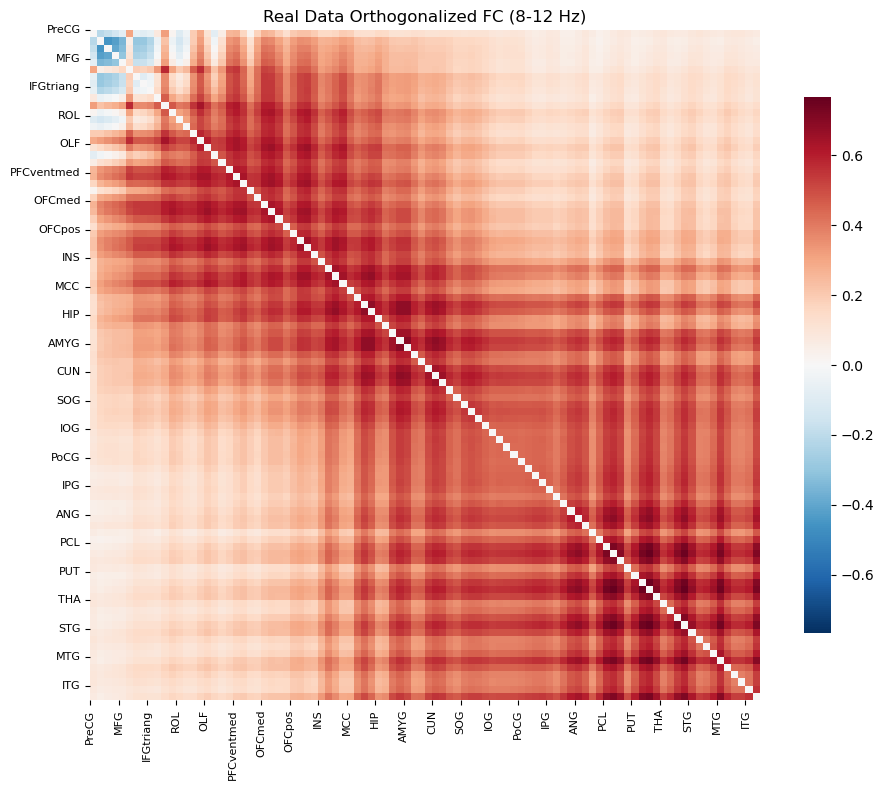

In [ ]:
# Execute the function with the parameters from the widgets
fc_matrix = calculate_orthogonalized_fc(
    meg_data=meg_array, 
    band=freq.value, 
    fs=fs, 
    low_pass_cutoff=low_pass.value
)

print("\nPlotting FC Matrix for real MEG data (Default Order)...")

fig_real, ax_real = plt.subplots(figsize=(10, 8))
plot_fc_heatmap(
    fc_matrix=fc_matrix,
    labels=region_labels, 
    title=f'Real Data Orthogonalized FC ({freq.value[0]}-{freq.value[1]} Hz)',
    ax=ax_real
)
plt.tight_layout()
plt.show()

Compute the functional-connectivity matrix from the synthetic data


Please select parameters for the simulation FC calculation:


IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=45, min=1, style=S…

FloatSlider(value=2.0, description='Low-Pass (Hz)', layout=Layout(width='80%'), max=4.0, readout_format='.1f',…

IntProgress(value=0, description='Computing FC:', layout=Layout(width='80%'), max=80, style=ProgressStyle(desc…

FC Matrix calculation complete.


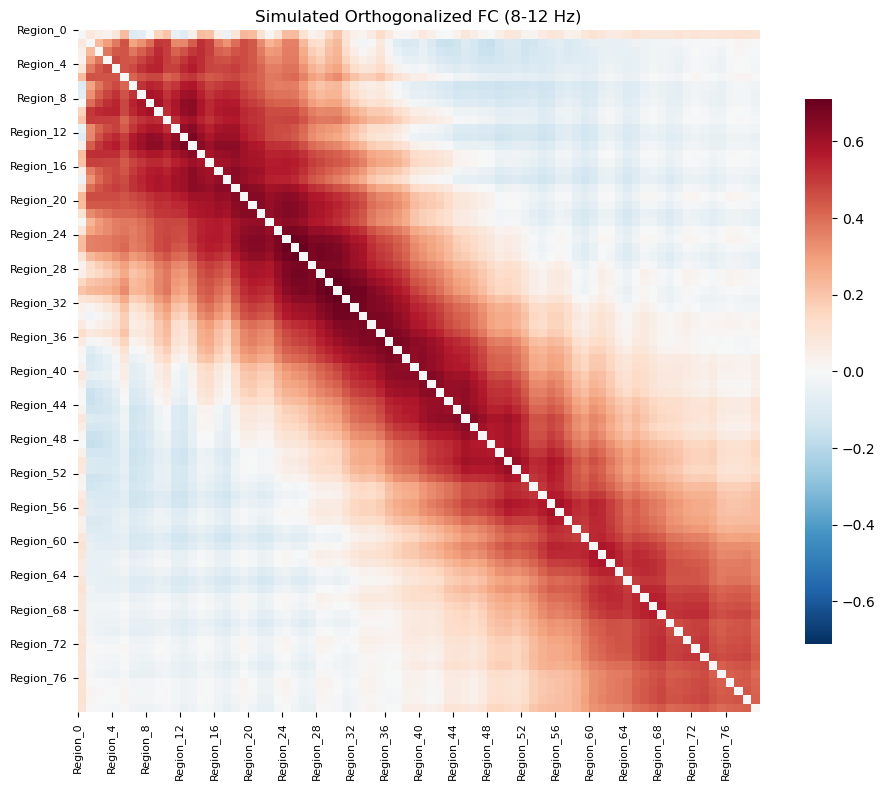

In [ ]:
print("\nPlease select parameters for the simulation FC calculation:")
sim_freq_band = widgets.IntRangeSlider(
    value=[8, 12], min=1, max=45, description='Frequency (Hz)',
    layout=widgets.Layout(width='80%'), style={'description_width': 'initial'}
)
sim_low_pass = widgets.FloatSlider(
    value=2.0, min=0, max=4.0, step=0.1, description='Low-Pass (Hz)',
    readout=True, readout_format='.1f',
    layout=widgets.Layout(width='80%'), style={'description_width': 'initial'}
)
display(sim_freq_band)
display(sim_low_pass)

fc_matrix_sim = calculate_orthogonalized_fc(
    meg_data=sim_signal,
    band=sim_freq_band.value,
    fs=target_fs,
    low_pass_cutoff=sim_low_pass.value
)

sim_labels = sim_signal.regions.values
fig_sim, ax_sim = plt.subplots(figsize=(10, 8))
plot_fc_heatmap(
    fc_matrix=fc_matrix_sim,
    labels=sim_labels, 
    title=f'Simulated Orthogonalized FC ({sim_freq_band.value[0]}-{sim_freq_band.value[1]} Hz)',
    ax=ax_sim
)
plt.tight_layout()
plt.show()

Flatten the simulated and real FC matrices into vectors, compute the Pearson correlation, and display the model fit with a bar plot to visually assess how well the simulated network reproduces the empirical MEG functional connectivity.


Comparing the 80x80 simulated FC with the corresponding subset of the real MEG FC.


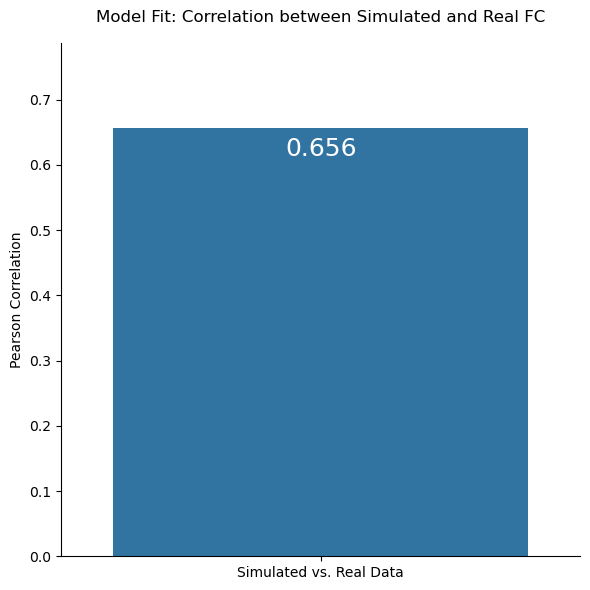

The correlation between the simulated FC and the real MEG data FC is: 0.656


In [26]:
num_sim_regions = fc_matrix_sim.shape[0]
fc_matrix_real_matched = fc_matrix[:num_sim_regions, :num_sim_regions]
print(f"\nComparing the {num_sim_regions}x{num_sim_regions} simulated FC with the corresponding subset of the real MEG FC.")
indices_triu = np.triu_indices(num_sim_regions, k=1)
real_fc_flat = fc_matrix_real_matched[indices_triu]
sim_fc_flat = fc_matrix_sim[indices_triu]

# Calculate the Pearson correlation between the two flattened FC vectors
sim_vs_real_corr = np.corrcoef(real_fc_flat, sim_fc_flat)[0, 1]
fig_comp, ax_comp = plt.subplots(figsize=(6, 6))

splot = sns.barplot(
    x=['Simulated vs. Real Data'],
    y=[sim_vs_real_corr],
    ax=ax_comp
)

ax_comp.set_ylabel('Pearson Correlation')
ax_comp.set_title('Model Fit: Correlation between Simulated and Real FC', pad=15)
ax_comp.set_ylim(0, max(0.5, sim_vs_real_corr * 1.2)) 

# Add the correlation value as text on the bar
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.3f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        size=18, color='white',
        xytext=(0, -15), 
        textcoords='offset points'
    )

sns.despine()
plt.tight_layout()
plt.show()
print(f"The correlation between the simulated FC and the real MEG data FC is: {sim_vs_real_corr:.3f}")